In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL)

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
#initializing ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 22s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
# Add additional layers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

#function for focal loss
def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Compiling model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4)                   #configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                     #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
#function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation
    # Calculate confusion matrix CHANGE THIS TO CM
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)   #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #Calculating precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/kaggle/input/isic-train-merge-aug/train_augumented-2023/train_augumented/task2"
test_dir = "/kaggle/input/isic-train-merge-aug/test2023/test/task2"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [16]:
model_path = f'/kaggle/working/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.8198
Epoch 1: val_accuracy improved from -inf to 0.90833, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_1.hdf5
96/96 [==============================] - 88s 363ms/step - loss: 0.0681 - accuracy: 0.8198 - val_loss: 0.0238 - val_accuracy: 0.9083 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.8708
Epoch 2: val_accuracy improved from 0.90833 to 0.94583, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_1.hdf5

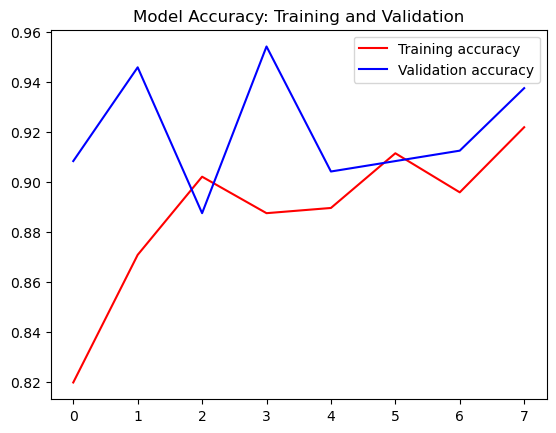

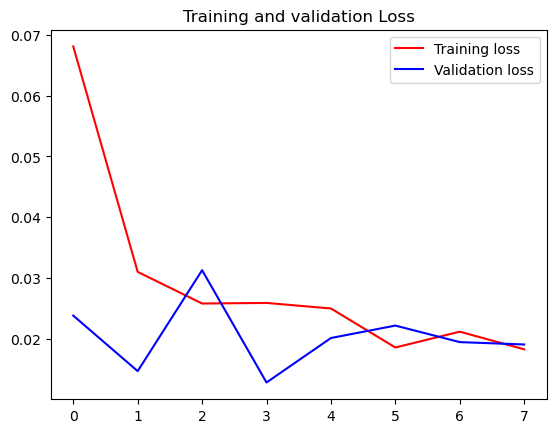

<Figure size 640x480 with 0 Axes>

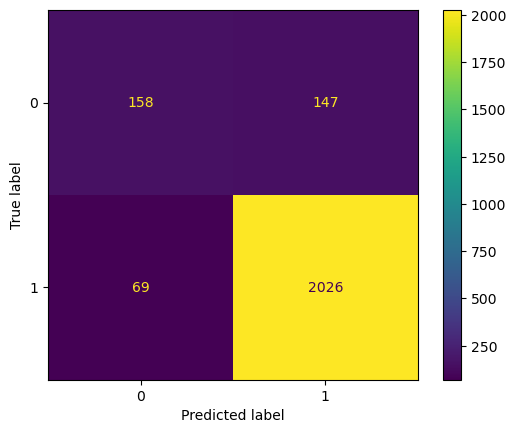


               precision    recall  f1-score   support

           0       0.70      0.52      0.59       305
           1       0.93      0.97      0.95      2095

    accuracy                           0.91      2400
   macro avg       0.81      0.74      0.77      2400
weighted avg       0.90      0.91      0.90      2400

Sensitivity: 0.967 Specificity: 0.518 Precision: 0.902 ROC_AUC_SCORE: 0.926



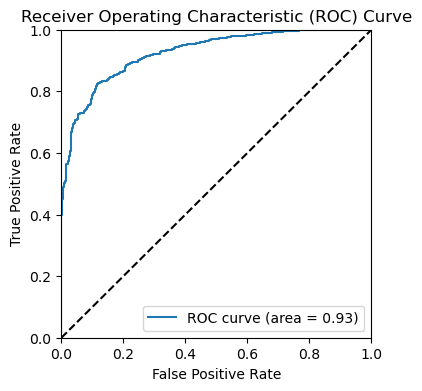

Validation complete...
Traning for Fold: 2
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.8875
Epoch 1: val_accuracy improved from -inf to 0.91250, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_2.hdf5
96/96 [==============================] - 78s 334ms/step - loss: 0.0262 - accuracy: 0.8875 - val_loss: 0.0189 - val_accuracy: 0.9125 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.8969
Epoch 2: val_accuracy improved from 0.91250 to 0.93333, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_

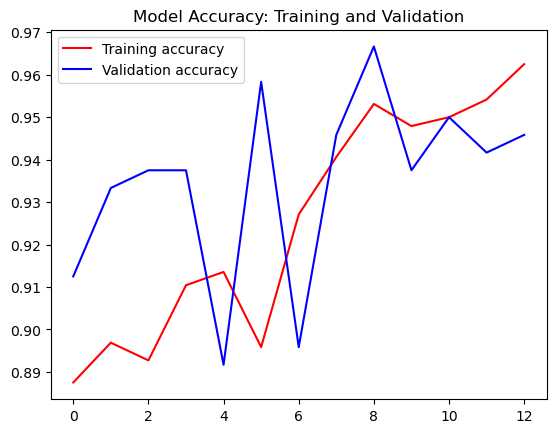

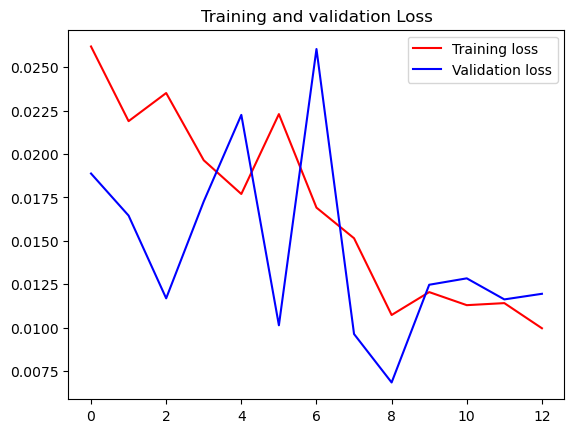

<Figure size 640x480 with 0 Axes>

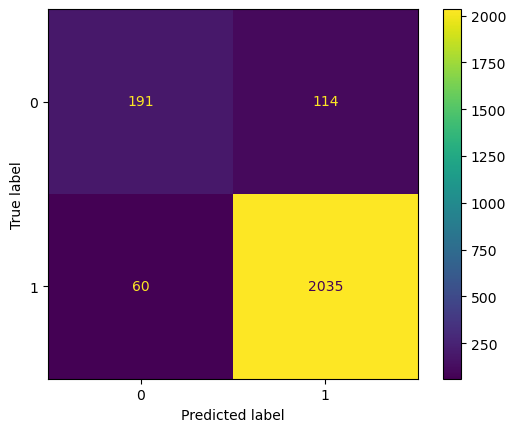


               precision    recall  f1-score   support

           0       0.76      0.63      0.69       305
           1       0.95      0.97      0.96      2095

    accuracy                           0.93      2400
   macro avg       0.85      0.80      0.82      2400
weighted avg       0.92      0.93      0.92      2400

Sensitivity: 0.971 Specificity: 0.626 Precision: 0.923 ROC_AUC_SCORE: 0.967



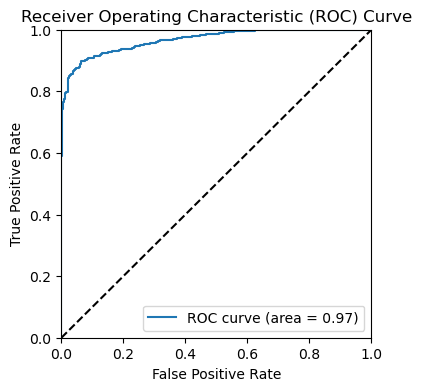

Validation complete...
Traning for Fold: 3
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9229
Epoch 1: val_accuracy improved from -inf to 0.96250, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_3.hdf5
96/96 [==============================] - 80s 348ms/step - loss: 0.0161 - accuracy: 0.9229 - val_loss: 0.0085 - val_accuracy: 0.9625 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9458
Epoch 2: val_accuracy did not improve from 0.96250
96/96 [==============================] - 28s 296ms/step - loss: 0.0141 - accuracy: 0.9458 - v

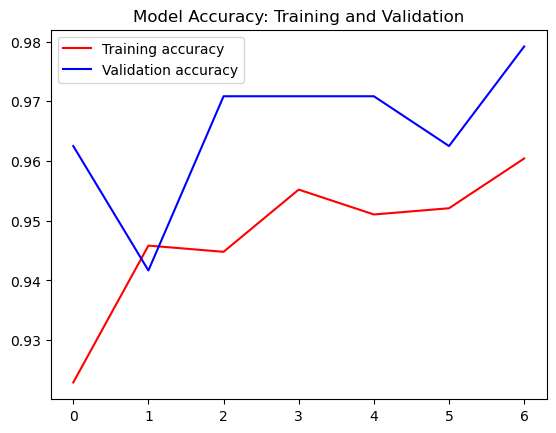

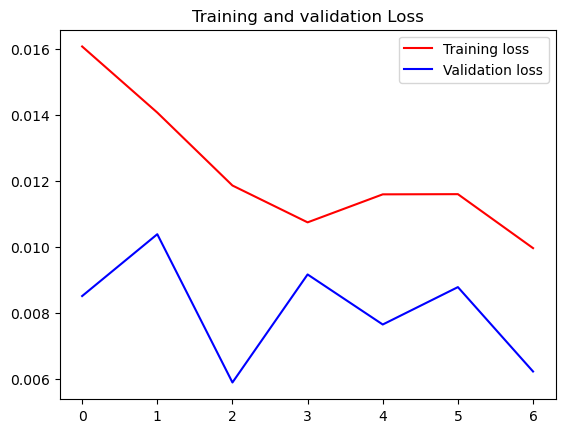

<Figure size 640x480 with 0 Axes>

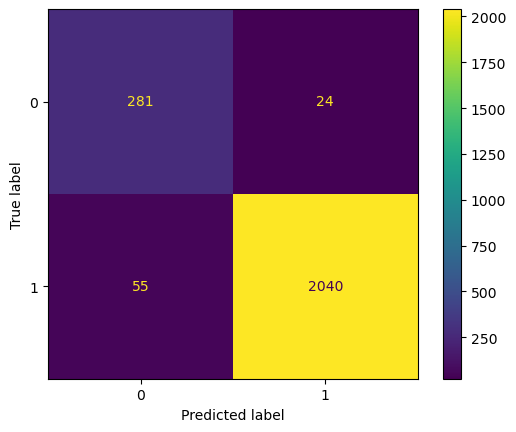


               precision    recall  f1-score   support

           0       0.84      0.92      0.88       305
           1       0.99      0.97      0.98      2095

    accuracy                           0.97      2400
   macro avg       0.91      0.95      0.93      2400
weighted avg       0.97      0.97      0.97      2400

Sensitivity: 0.974 Specificity: 0.921 Precision: 0.969 ROC_AUC_SCORE: 0.992



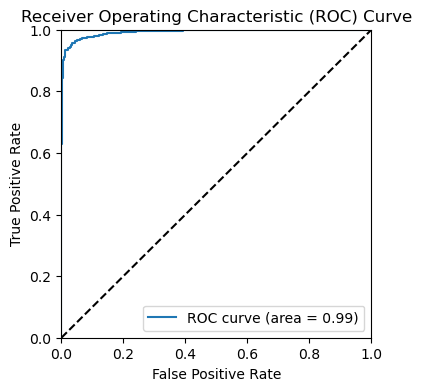

Validation complete...
Traning for Fold: 4
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9583
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_4.hdf5
96/96 [==============================] - 80s 340ms/step - loss: 0.0105 - accuracy: 0.9583 - val_loss: 0.0049 - val_accuracy: 0.9750 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9531
Epoch 2: val_accuracy improved from 0.97500 to 0.97917, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_

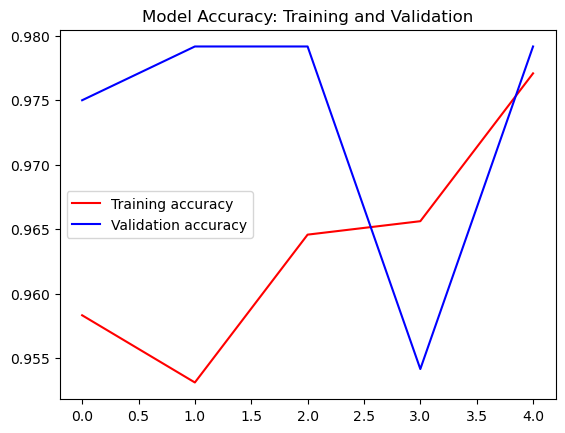

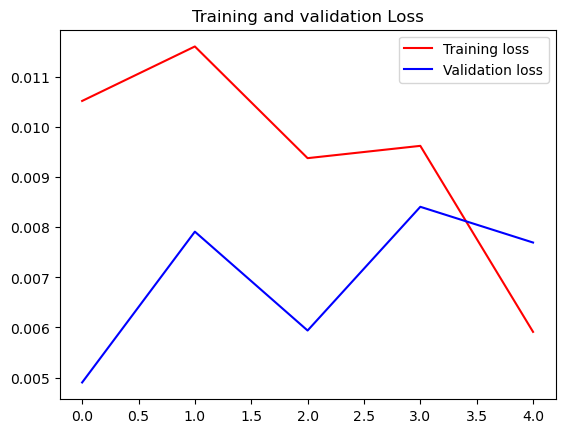

<Figure size 640x480 with 0 Axes>

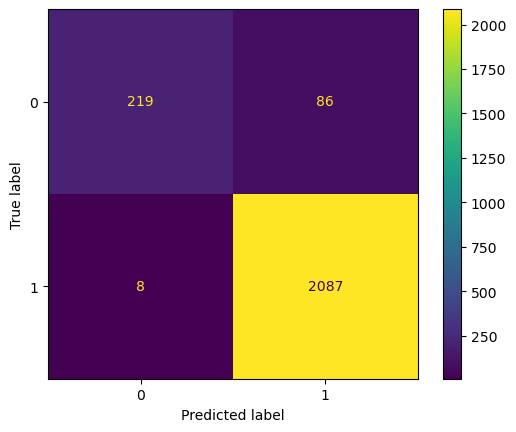


               precision    recall  f1-score   support

           0       0.96      0.72      0.82       305
           1       0.96      1.00      0.98      2095

    accuracy                           0.96      2400
   macro avg       0.96      0.86      0.90      2400
weighted avg       0.96      0.96      0.96      2400

Sensitivity: 0.996 Specificity: 0.718 Precision: 0.961 ROC_AUC_SCORE: 0.991



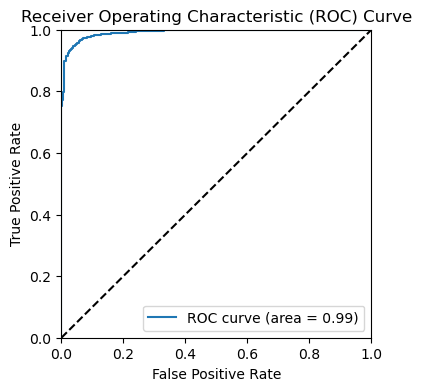

Validation complete...
Traning for Fold: 5
Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9542
Epoch 1: val_accuracy improved from -inf to 0.97083, saving model to /kaggle/working/model/seb_vs_nev&mel_with_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_5.hdf5
96/96 [==============================] - 80s 341ms/step - loss: 0.0120 - accuracy: 0.9542 - val_loss: 0.0078 - val_accuracy: 0.9708 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9677
Epoch 2: val_accuracy did not improve from 0.97083
96/96 [==============================] - 28s 296ms/step - loss: 0.0087 - accuracy: 0.9677 - v

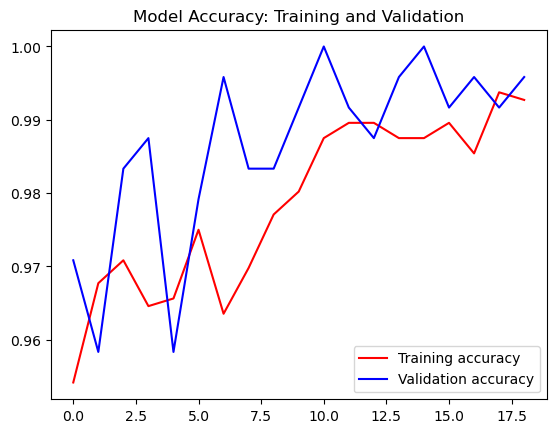

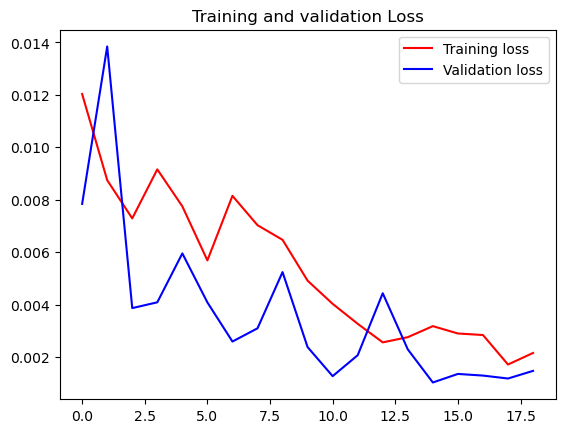

<Figure size 640x480 with 0 Axes>

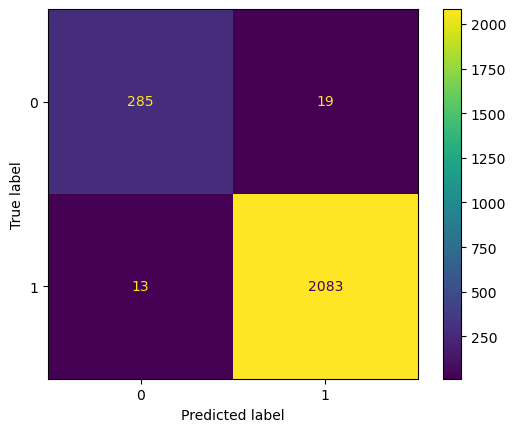


               precision    recall  f1-score   support

           0       0.96      0.94      0.95       304
           1       0.99      0.99      0.99      2096

    accuracy                           0.99      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.99      0.99      0.99      2400

Sensitivity: 0.994 Specificity: 0.938 Precision: 0.987 ROC_AUC_SCORE: 0.998



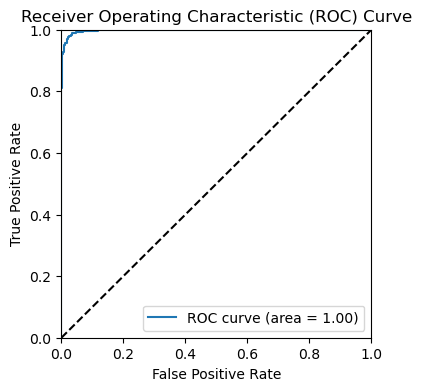

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)

    # Evaluate the model on the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


In [18]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 20s 33ms/step


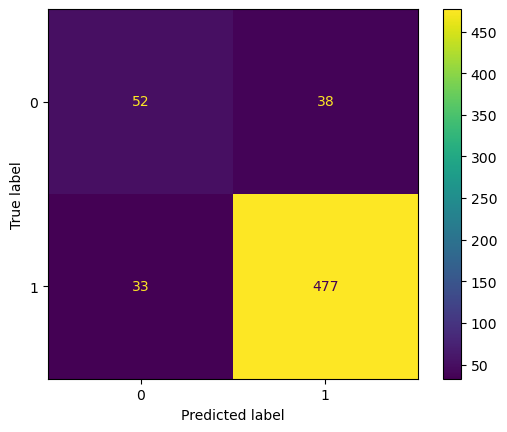


               precision    recall  f1-score   support

           0       0.61      0.58      0.59        90
           1       0.93      0.94      0.93       510

    accuracy                           0.88       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.88      0.88      0.88       600

Sensitivity: 0.935 Specificity: 0.578 Precision: 0.879 ROC_AUC_SCORE: 0.89



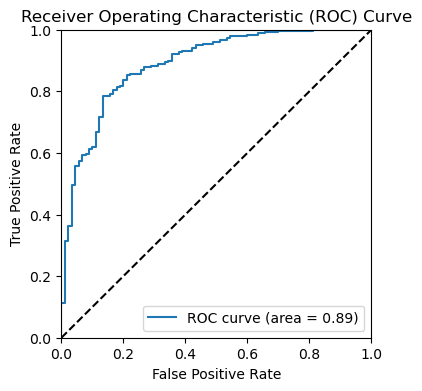

Testing Complete
Test using model 2
600/600 [==============================] - 20s 33ms/step


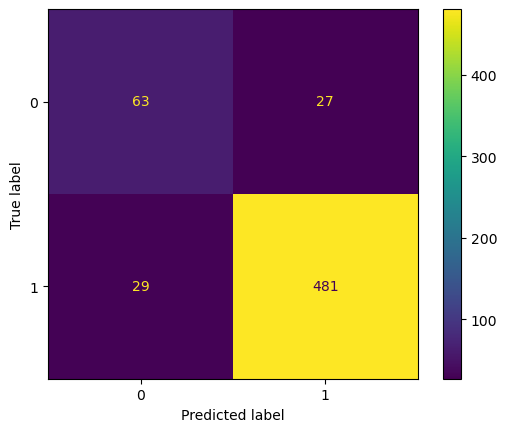


               precision    recall  f1-score   support

           0       0.68      0.70      0.69        90
           1       0.95      0.94      0.94       510

    accuracy                           0.91       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.91      0.91      0.91       600

Sensitivity: 0.943 Specificity: 0.7 Precision: 0.908 ROC_AUC_SCORE: 0.94



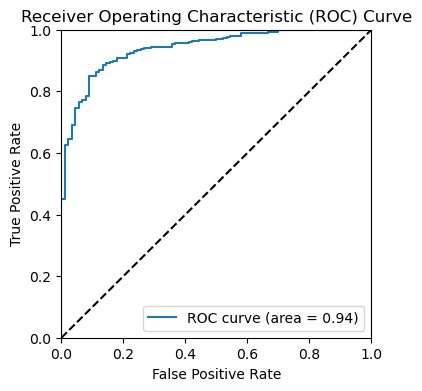

Testing Complete
Test using model 3
600/600 [==============================] - 19s 32ms/step


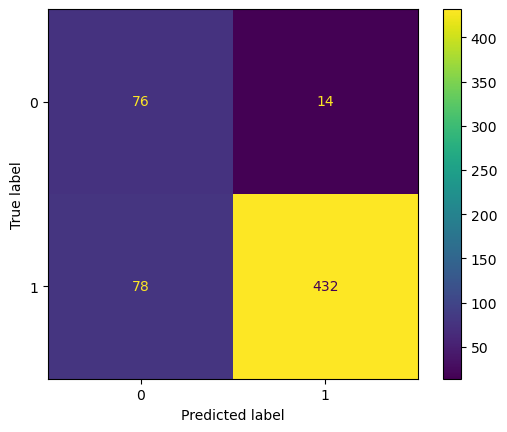


               precision    recall  f1-score   support

           0       0.49      0.84      0.62        90
           1       0.97      0.85      0.90       510

    accuracy                           0.85       600
   macro avg       0.73      0.85      0.76       600
weighted avg       0.90      0.85      0.86       600

Sensitivity: 0.847 Specificity: 0.844 Precision: 0.897 ROC_AUC_SCORE: 0.926



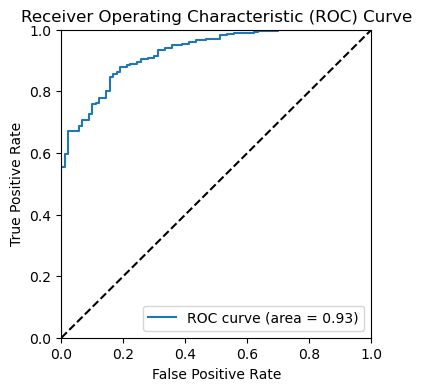

Testing Complete
Test using model 4
600/600 [==============================] - 20s 33ms/step


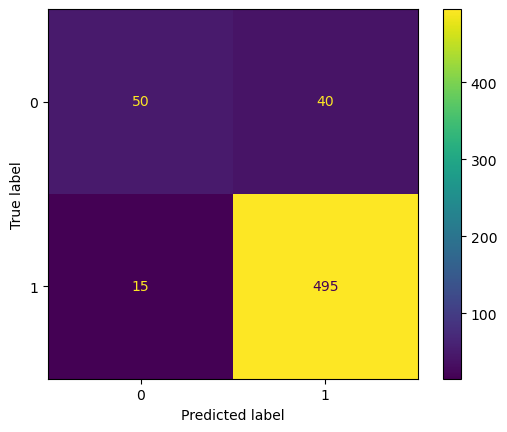


               precision    recall  f1-score   support

           0       0.77      0.56      0.65        90
           1       0.93      0.97      0.95       510

    accuracy                           0.91       600
   macro avg       0.85      0.76      0.80       600
weighted avg       0.90      0.91      0.90       600

Sensitivity: 0.971 Specificity: 0.556 Precision: 0.902 ROC_AUC_SCORE: 0.939



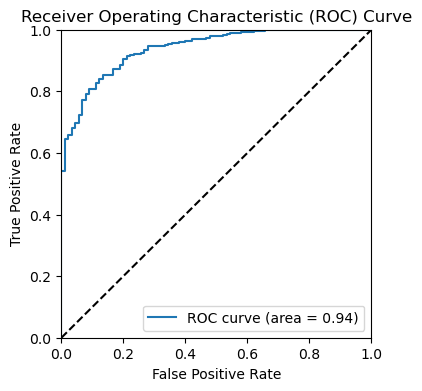

Testing Complete
Test using model 5
600/600 [==============================] - 20s 34ms/step


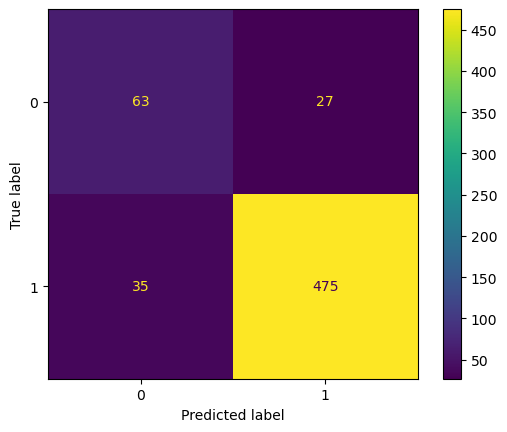


               precision    recall  f1-score   support

           0       0.64      0.70      0.67        90
           1       0.95      0.93      0.94       510

    accuracy                           0.90       600
   macro avg       0.79      0.82      0.80       600
weighted avg       0.90      0.90      0.90       600

Sensitivity: 0.931 Specificity: 0.7 Precision: 0.901 ROC_AUC_SCORE: 0.934



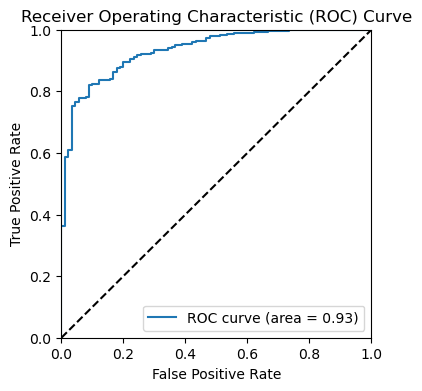

Testing Complete


In [19]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")